## Emergency Department Volume Forecasting (Demonstration Version)

This project demonstrates an ARIMA-based forecasting approach for modeling Emergency Department (ED) patient volume. **Please note** that for demonstration purposes, this version uses publicly available air passenger data in place of actual ED data. The variable names have been retained for consistency with the original project.

To protect the integrity of my work and maintain intellectual ownership, some parts of the code—particularly those related to proprietary preprocessing and feature engineering—have been intentionally omitted.

### About the Full Model:
In the complete version of this project, I incorporated multiple external regressors to enhance forecast accuracy, including:
- Seasonality indicators
- Holiday effects
- Special event periods (e.g., flu season surges)

For simplicity, this notebook highlights the core ARIMA modeling workflow applied to the cleaned time series data.



In [55]:
# !pip install pandas numpy pantab tableauhyperapi statsmodels matplotlib seaborn scikit-learn openpyxl

In [1]:
import datetime as dt
import pandas as pd
import pantab as pt
from tableauhyperapi import TableName
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import autocorrelation_plot
from matplotlib.ticker import MultipleLocator
from functools import reduce
import warnings
from sklearn.linear_model import LinearRegression
from datetime import timedelta
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
warnings.filterwarnings("ignore")
import os
import openpyxl
import itertools
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

In [13]:
# Load AirPassengers dataset
raw_data = sm.datasets.get_rdataset("AirPassengers", package="datasets").data

# Convert to datetime and rename columns
raw_data['Date'] = pd.date_range(start='1949-01', periods=len(raw_data), freq='M')
raw_data.rename(columns={'value': 'Volume'}, inplace=True)

# Reorder columns and set 'Date' as index if needed
data = raw_data[['Date', 'Volume']]
data.set_index('Date', inplace=True)

# Preview the result
data

,Volume
Date,
1949-01-31,112
1949-02-28,118
1949-03-31,132
1949-04-30,129
1949-05-31,121
...,...
1960-08-31,606
1960-09-30,508
1960-10-31,461


In [14]:
# seasonally decomposes daily volume data and shows graphs
def seasonally_decompose_volume(volume_df):
    """
    Performs seasonal decomposition on daily volume data, visualizes the components, 
    and generates fiscal year-aligned trend analyses.

    Parameters:
    -----------
    volume_df : pandas.DataFrame
        A DataFrame indexed by datetime, containing a 'Volume' column representing daily values.

    Returns:
    --------
    pandas.DataFrame
        A DataFrame with the original volume data and three additional columns:
        - 'trend': The long-term trend component
        - 'seasonal_trend': The seasonal variation component
        - 'residual_trend': The residual (noise) component

    Visualizations:
    ---------------
    - Decomposition plot (original, trend, seasonal, residual)
    - Year-over-year line plot of volume by fiscal month
    - Heatmap of monthly volumes by fiscal year
    - Autocorrelation plot of the volume series

    Notes:
    ------
    - Fiscal years are assigned such that September starts the fiscal year (i.e., FY starts in September).
    - For visualization, fiscal months are reordered so September = 1, October = 2, ..., August = 12.
    """
    df_monthly = volume_df.copy()
    
    # Perform seasonal decomposition
    decomposition = sm.tsa.seasonal_decompose(df_monthly['Volume'], model='additive', period=12)
    
    # Extract components
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    df_monthly['trend'] = trend
    df_monthly['seasonal_trend'] = seasonal
    df_monthly['residual_trend'] = residual

    # ORIGINAL
    plt.figure(figsize=(12, 8))
    
    plt.subplot(4, 1, 1)
    plt.plot(df_monthly.index, df_monthly['Volume'], label='Original Data', color='blue')
    plt.legend()
    # TREND
    plt.subplot(4, 1, 2)
    plt.plot(df_monthly.index, trend, label='Trend', color='red')
    plt.legend()
    # SEASONAL
    plt.subplot(4, 1, 3)
    plt.plot(df_monthly.index, seasonal, label='Seasonality', color='green')
    plt.legend()
    #RESIDUAL
    plt.subplot(4, 1, 4)
    plt.plot(df_monthly.index, residual, label='Residuals', color='purple')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

    # **Correcting Fiscal Year Assignment**
    df_monthly['Fiscal_Year'] = np.where(df_monthly.index.month >= 9, df_monthly.index.year + 1, df_monthly.index.year)
    df_monthly['FY_Label'] = 'FY' + df_monthly['Fiscal_Year'].astype(str).str[-2:]

    # **Assigning Fiscal Month Order (September = 1, October = 2, ..., August = 12)**
    df_monthly['Fiscal_Month'] = (df_monthly.index.month - 9) % 12 + 1

    # **YEAR-OVER-YEAR MONTHLY TRENDS (Fiscal Year Labels)**
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df_monthly, x='Fiscal_Month', y='Volume', hue='FY_Label', palette='coolwarm')

    plt.title('Year-over-Year Monthly Trends')
    plt.xlabel('Fiscal Month')
    plt.ylabel('ED Volume')
    plt.xticks(range(1, 13), ['Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug'])
    plt.legend(title='Fiscal Year')
    plt.show()

    # **HEATMAP OF MONTHLY VOLUME (Most Recent Year at Top)**
    df_pivot = df_monthly.pivot(index='FY_Label', columns='Fiscal_Month', values='Volume')
    df_pivot = df_pivot.sort_index(ascending=False)  # Sort so the most recent year appears first

    plt.figure(figsize=(12, 6))
    sns.heatmap(df_pivot, cmap='coolwarm', annot=True, fmt=".0f")

    plt.title('Heatmap of ED Volumes (Monthly)')
    plt.xlabel('Fiscal Month')
    plt.ylabel('Fiscal Year')
    plt.yticks(rotation=0)  # Keep fiscal year labels horizontal
    plt.xticks(range(12), ['Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug'])
    plt.show()

    # AUTOCORRELATION
    plt.figure(figsize=(10, 5))
    autocorrelation_plot(df_monthly['Volume'])
    plt.title('Autocorrelation of ED Volume')
    # Set x-axis ticks to go up by 5s
    plt.gca().xaxis.set_major_locator(MultipleLocator(5))    
    plt.show()

    return df_monthly[['Volume','trend','seasonal_trend','residual_trend']]

# Visualizations

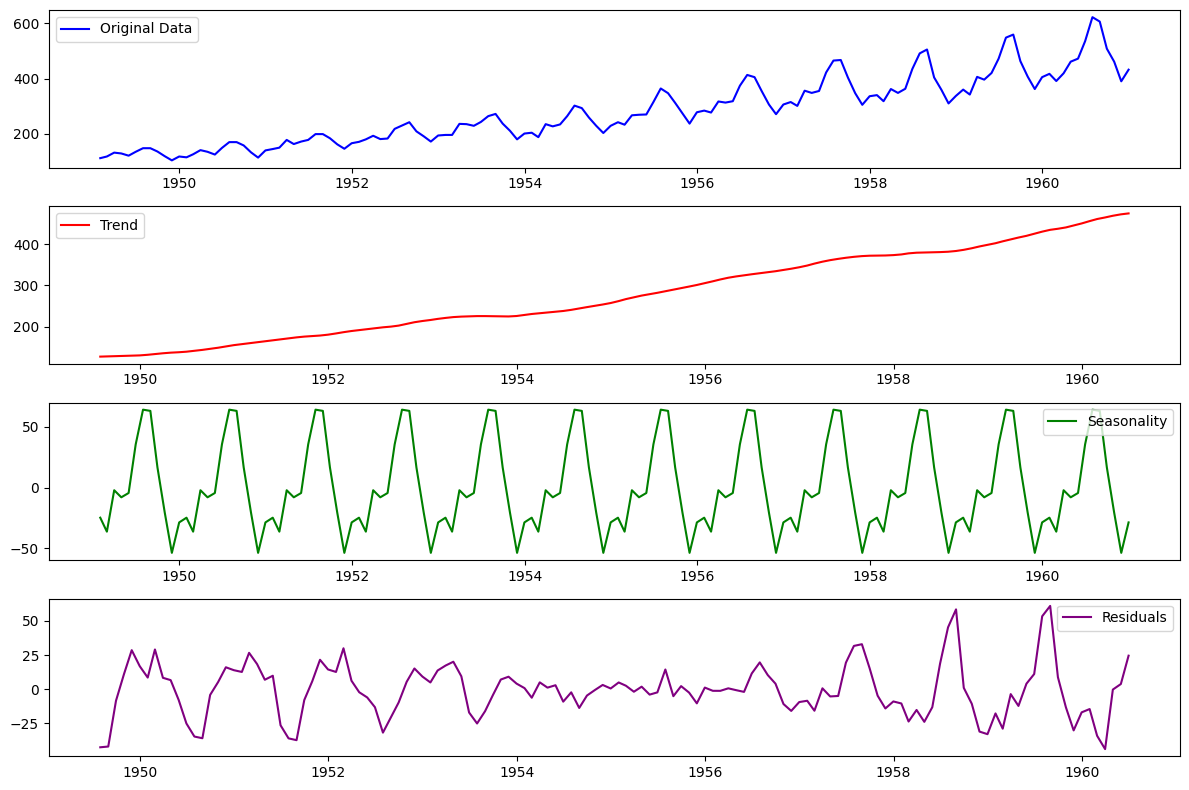

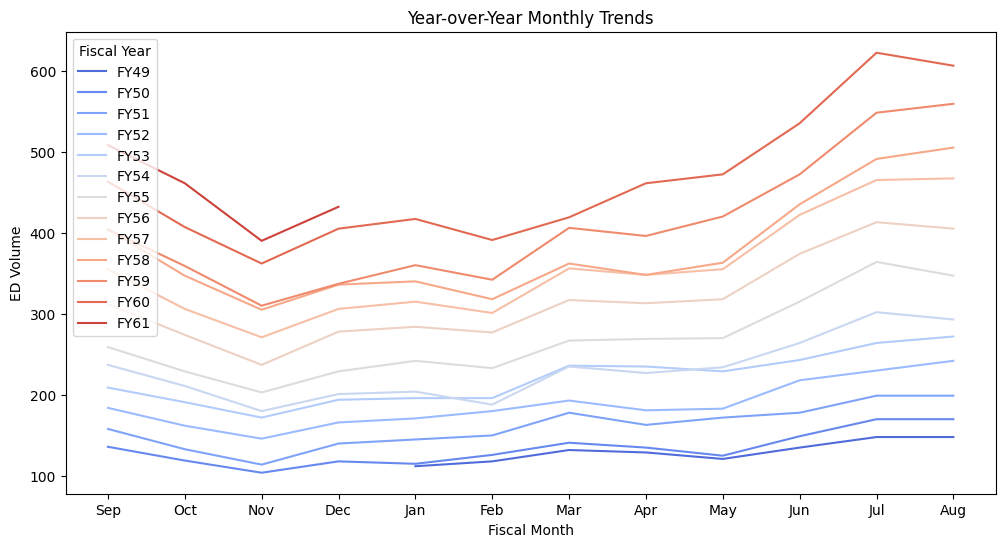

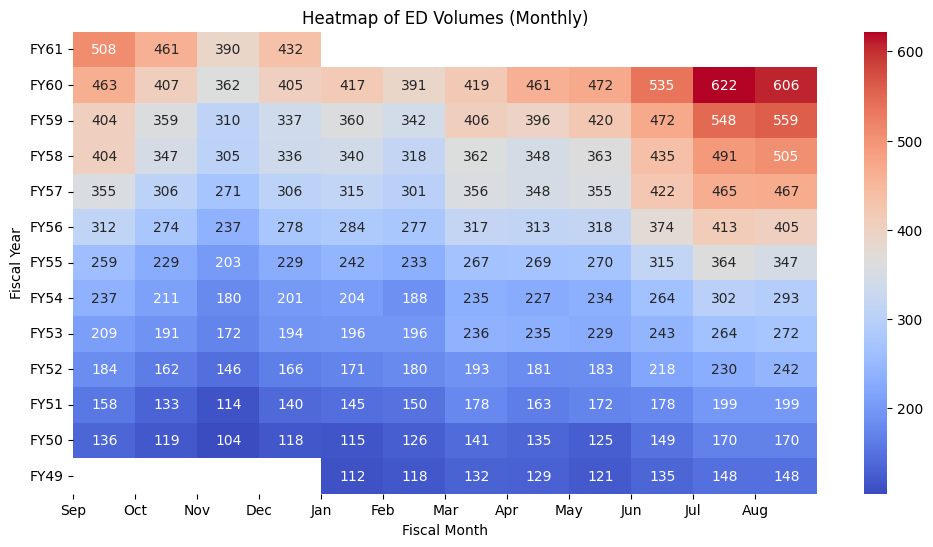

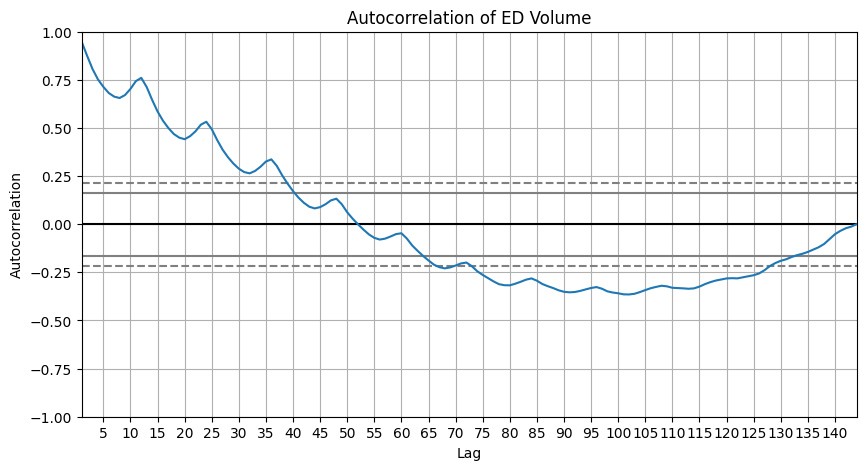

In [15]:
data_monthly = seasonally_decompose_volume(data)

# Compile External Factors

In [45]:
# Add Dummy Variables
def create_dummies(start_date="1949-01-01", end_date="1961-01-01"):
    """
    Generates a DataFrame of monthly dummy variables between two dates for use in time series modeling.

    Parameters:
    -----------
    start_date : str, default "1949-01-01"
        The start of the date range (must be a valid date string).
    end_date : str, default "1961-01-01"
        The end of the date range (must be a valid date string).

    Returns:
    --------
    pandas.DataFrame
        A DataFrame indexed by month containing the following dummy variables:
        - One-hot encoded month indicators (e.g., 'January', 'February', ...)
        - `Flu_Season`: 1 if the month is December through March
        - `Covid_Period`: 1 for dates between March 2020 and November 2021
        - `Christmas`: 1 for December
        - `Thanksgiving`: 1 for Nov 22–28 (approximate window)
        - `New_Years`: 1 for January
        - `Independence_Day`: 1 for July

    """
    # Create a date range
    date_range = pd.date_range(start=start_date, end=end_date, freq="M")
    
    # Create DataFrame
    df = pd.DataFrame({"Date": date_range})
    
    # Extract month and year
    df["Year"] = df["Date"].dt.year
    df["Month"] = df["Date"].dt.strftime("%B")  # Convert month number to full name
    
    # Create dummy variables for each month
    months = df["Month"].unique()
    for month in months:
        df[f"{month}"] = (df["Month"] == month).astype(int)
    
    # Flu season dummy (December - March)
    df["Flu_Season"] = df["Month"].isin(["December", "January", "February", "March"]).astype(int)
    
    # COVID period dummy (March 2020 - November 2021)
    df["Covid_Period"] = ((df["Date"] >= "2020-03-01") & (df["Date"] <= "2021-11-30")).astype(int)
    
    # Holiday dummies
    df["Christmas"] = (df["Month"] == "December").astype(int)
    df["Thanksgiving"] = ((df["Month"] == "November") & (df["Date"].dt.day >= 22) & (df["Date"].dt.day <= 28)).astype(int)
    df["New_Years"] = (df["Month"] == "January").astype(int)
    df["Independence_Day"] = (df["Month"] == "July").astype(int)

    df = df.drop(columns = ['Year','Month'])

    return df

dummies = create_dummies()
dummies

,Date,January,February,March,April,May,June,July,August,September,October,November,December,Flu_Season,Covid_Period,Christmas,Thanksgiving,New_Years,Independence_Day
0,1949-01-31,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1,1949-02-28,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,1949-03-31,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,1949-04-30,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1949-05-31,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,1960-08-31,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
140,1960-09-30,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
141,1960-10-31,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
142,1960-11-30,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


# FIND ARIMA PARAMATERS

In [17]:
def grid_search_arima(df, col, p_max, d_max, q_max):
     """
    Performs a grid search over ARIMA hyperparameters to find the best model based on AIC.

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing the time series data.
    col : str
        Column name in `df` to be used as the time series for ARIMA modeling.
    p_max : int
        Maximum value of AR (autoregressive) order to try.
    d_max : int
        Maximum value of differencing order to try.
    q_max : int
        Maximum value of MA (moving average) order to try.

    Returns:
    --------
    best_model : statsmodels.tsa.arima.model.ARIMAResults
        The fitted ARIMA model with the lowest AIC.
    best_order : tuple
        The (p, d, q) order corresponding to the best model.
    train : pandas.Series or DataFrame
        The training subset of the time series used in model fitting.
    test : pandas.Series or DataFrame
        The test subset of the time series reserved for validation.
    """
   # (Code Omitted)

In [37]:
def find_data_interpretations(df, original_col, forecast_col):
      """
    Calculates and prints key regression error metrics comparing actual and forecasted values.

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing the original and forecasted data columns.
    original_col : str
        Name of the column in `df` with actual observed values.
    forecast_col : str
        Name of the column in `df` with forecasted or predicted values.

    Prints:
    -------
    - Mean Absolute Error (MAE)
    - Mean Absolute Percentage Error (MAPE)
    - Root Mean Squared Error (RMSE)
    - R-squared (R²) score

    """
    df = df.copy().dropna()
    # Calculate and print error metrics for the test period
    mae = mean_absolute_error(df[original_col], df[forecast_col])
    mape = mean_absolute_percentage_error(df[original_col], df[forecast_col]) * 100  # Convert to %
    rmse = np.sqrt(mean_squared_error(df[original_col], df[forecast_col]))
    r2 = r2_score(df[original_col], df[forecast_col])
    
    print("Mean Absolute Error (MAE) – Average absolute difference between actual & predicted values: ")
    print(f"MAE: {mae:.2f}")
    print("Mean Absolute Percentage Error (MAPE) – Percentage error relative to actual values: ")
    print(f"MAPE: {mape:.2f}%")
    print("Root Mean Squared Error (RMSE) – Penalizes larger errors more than MAE.:")
    print(f"RMSE: {rmse:.2f}")
    print("R-Squared (R^2) – Shows how well the model is doing on a scale from 0-1:")
    print(f"R-Squared: {r2:.2f}")

In [19]:
def show_results(best_model, train, test, col):
    """
    Visualizes ARIMA model performance by plotting fitted values on training data,
    forecasts on the test set, and extended future forecasts. Also calculates and prints
    error metrics on the test set.

    Parameters:
    -----------
    best_model : statsmodels ARIMAResults object
        The fitted ARIMA model used for forecasting.
    train : pandas.DataFrame
        Training dataset containing actual values in column `col`.
    test : pandas.DataFrame
        Test dataset containing actual values in column `col`.
    col : str
        Name of the column representing the observed values in both train and test datasets.

    Returns:
    --------
    pandas.DataFrame
        Combined DataFrame containing the original test data and the forecasted values
        for both the test period and an extended future period (next 5 years).

    Printed Outputs:
    -------------
    - Prints regression error metrics (MAE, MAPE, RMSE, R²) for the test data.
    - Generates a multi-line plot showing:
      * Actual vs. fitted values on training data
      * Actual vs. forecasted values on test data
      * Forecasted values for the extended future period
    """
    # Get in-sample fitted values (model predictions for training data)
    train['Fitted'] = best_model.fittedvalues

    # Forecast for the combined period: test period + next 5 years (60 months)
    total_steps = len(test) + 61  # Test set length + 60 months (5 years)
    
    # Generate the forecast for the full period (test period + next 5 years)
    combined_forecast = best_model.forecast(steps=total_steps)
    forecast_df = pd.DataFrame(combined_forecast).rename(columns={'predicted_mean':'Forecast'})

    # Print error metrics for the test period
    find_data_interpretations(test, col, 'Forecast')

    # Plot results
    plt.figure(figsize=(12, 6))

    # Plot training data and fitted values
    plt.plot(train.index, train[col], label='Training Data (Actual)', color='blue')
    plt.plot(train.index[2:], train['Fitted'][2:], label='Fitted Values (Training)', color='cyan', linestyle='dashed')

    # Plot actual test data and forecast
    plt.plot(test.index, test[col], label='Actual Test Data', color='black')
    plt.plot(test.index, test['Forecast'], label='Forecast (Test)', color='red', linestyle='dashed')

    # Plot forecast for the next 5 years
    plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast (Future)', color='green', linestyle='dashed')

    plt.title('ARIMA Model - Fitted & Forecasted vs Actuals')
    plt.xlabel('Date')
    plt.ylabel('Volume')
    plt.legend()
    plt.show()

    # Return the combined dataframe with both the test data and forecasted data
    final_df = pd.concat([test, forecast_df], axis=0)
    return final_df


In [34]:
def create_total_forecast(monthly_df, trend_forecast, seasonal_forecast, residual_forecast):
    """
    Combines individual forecast components—trend, seasonal, and residual—into a total forecast series.

    Parameters:
    -----------
    monthly_df : pandas.DataFrame
        Original monthly data frame with the actual time series data (used for index alignment).
    trend_forecast : array-like or pandas.Series
        Forecasted values of the trend component.
    seasonal_forecast : array-like or pandas.Series
        Forecasted values of the seasonal component.
    residual_forecast : array-like or pandas.Series
        Forecasted values of the residual component.

    Returns:
    --------
    pandas.Series
        Combined total forecast computed by summing trend, seasonal, and residual components,
        indexed to align with the input monthly_df.
    """
    # (Code Omitted)

# FORECAST

#### Trend

In [22]:
best_model_trend, best_order_trend, train_trend, test_trend = grid_search_arima(data_monthly)

Error with ARIMA(7,0,0): LU decomposition error.
Error with ARIMA(11,0,5): LU decomposition error.
Best ARIMA Model: ARIMA(0, 2, 1) with RMSE: 1.1036091406088888


Mean Absolute Error (MAE) – Average absolute difference between actual & predicted values: 
MAE: 0.94
Mean Absolute Percentage Error (MAPE) – Percentage error relative to actual values: 
MAPE: 0.21%
Root Mean Squared Error (RMSE) – Penalizes larger errors more than MAE.:
RMSE: 1.10
R-Squared (R^2) – Shows how well the model is doing on a scale from 0-1:
R-Squared: 1.00


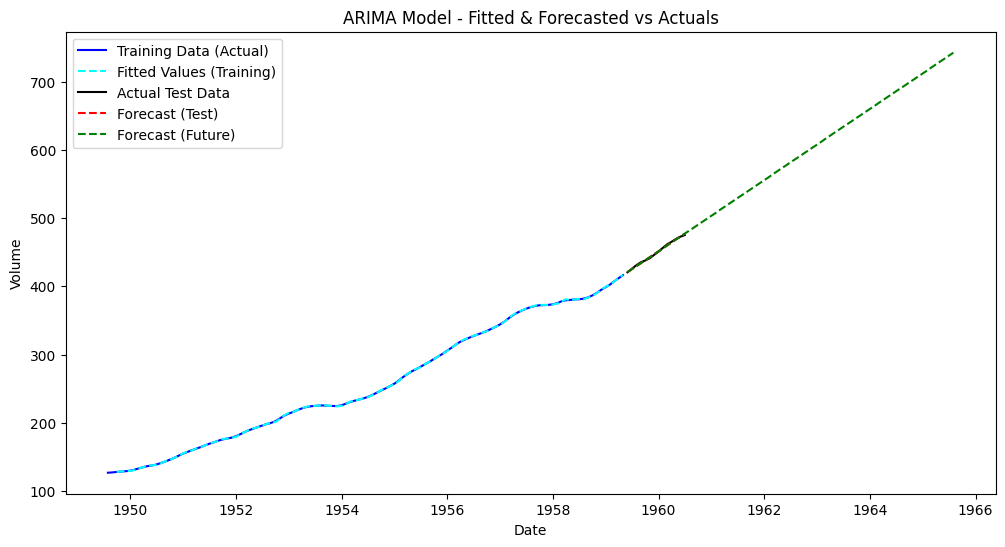

In [23]:
trend = show_results(best_model_trend, train_trend, test_trend, 'trend')

In [25]:
trend

,trend,Forecast
1959-05-31,420.500000,420.679315
1959-06-30,425.500000,425.025297
1959-07-31,430.708333,429.371280
1959-08-31,435.125000,433.717262
1959-09-30,437.708333,438.063244
...,...,...
1965-03-31,NaN,724.898060
1965-04-30,NaN,729.244042
1965-05-31,NaN,733.590024
1965-06-30,NaN,737.936006


#### Seasonal

In [30]:
best_model_seasonal, best_order_seasonal, train_seasonal, test_seasonal = grid_search_arima(data_monthly,'seasonal_trend', 12, 3, 12)

Error with ARIMA(6,0,7): LU decomposition error.
Error with ARIMA(7,1,6): LU decomposition error.
Error with ARIMA(9,1,12): LU decomposition error.
Error with ARIMA(11,1,5): LU decomposition error.
Error with ARIMA(11,3,6): LU decomposition error.
Error with ARIMA(11,3,7): LU decomposition error.
Error with ARIMA(11,3,12): LU decomposition error.
Error with ARIMA(12,1,3): LU decomposition error.
Error with ARIMA(12,1,10): LU decomposition error.
Error with ARIMA(12,1,12): LU decomposition error.
Error with ARIMA(12,3,0): LU decomposition error.
Error with ARIMA(12,3,9): LU decomposition error.
Best ARIMA Model: ARIMA(11, 0, 0) with RMSE: 0.08982971483410475


Mean Absolute Error (MAE) – Average absolute difference between actual & predicted values: 
MAE: 0.08
Mean Absolute Percentage Error (MAPE) – Percentage error relative to actual values: 
MAPE: 0.65%
Root Mean Squared Error (RMSE) – Penalizes larger errors more than MAE.:
RMSE: 0.09
R-Squared (R^2) – Shows how well the model is doing on a scale from 0-1:
R-Squared: 1.00


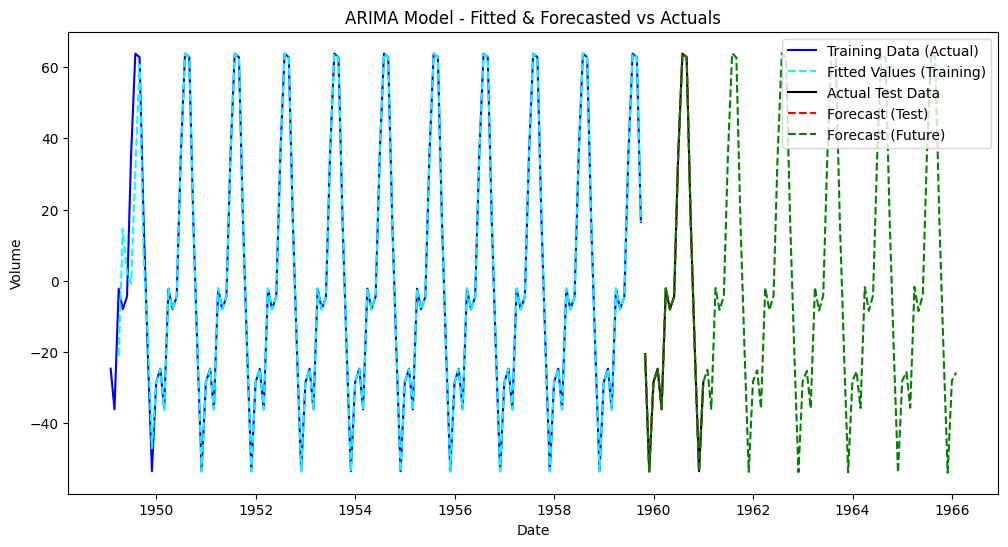

In [32]:
seasonal = show_results(best_model_seasonal, train_seasonal, test_seasonal, 'seasonal_trend')

#### Residual

In [28]:
best_model_residual, best_order_residual, train_residual, test_residual = grid_search_arima(data_monthly,'residual_trend')

Best ARIMA Model: ARIMA(6, 0, 6) with RMSE: 13.595636165824393


Mean Absolute Error (MAE) – Average absolute difference between actual & predicted values: 
MAE: 9.79
Mean Absolute Percentage Error (MAPE) – Percentage error relative to actual values: 
MAPE: 369.82%
Root Mean Squared Error (RMSE) – Penalizes larger errors more than MAE.:
RMSE: 13.60
R-Squared (R^2) – Shows how well the model is doing on a scale from 0-1:
R-Squared: 0.79


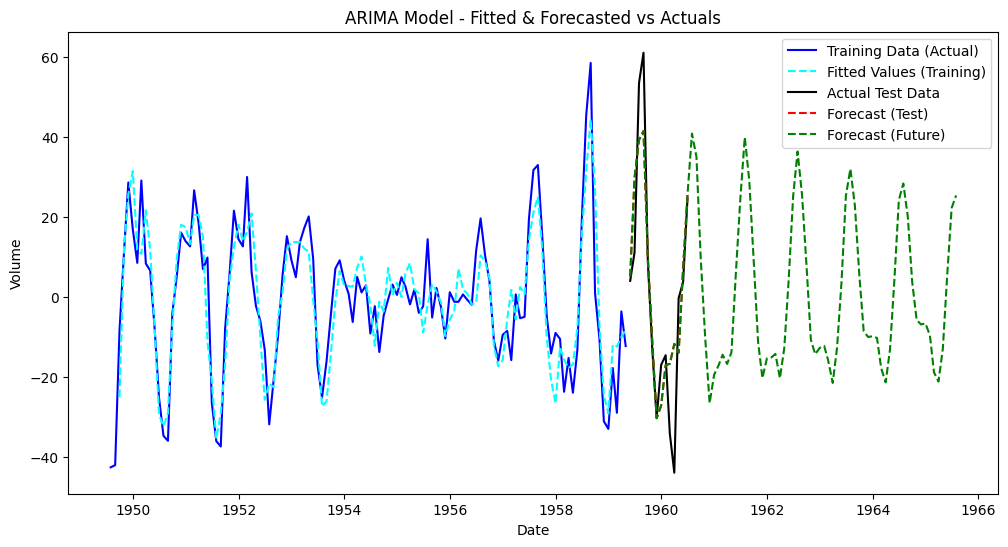

In [29]:
residual = show_results(best_model_residual, train_residual, test_residual, 'residual_trend')

#### Total Forecast

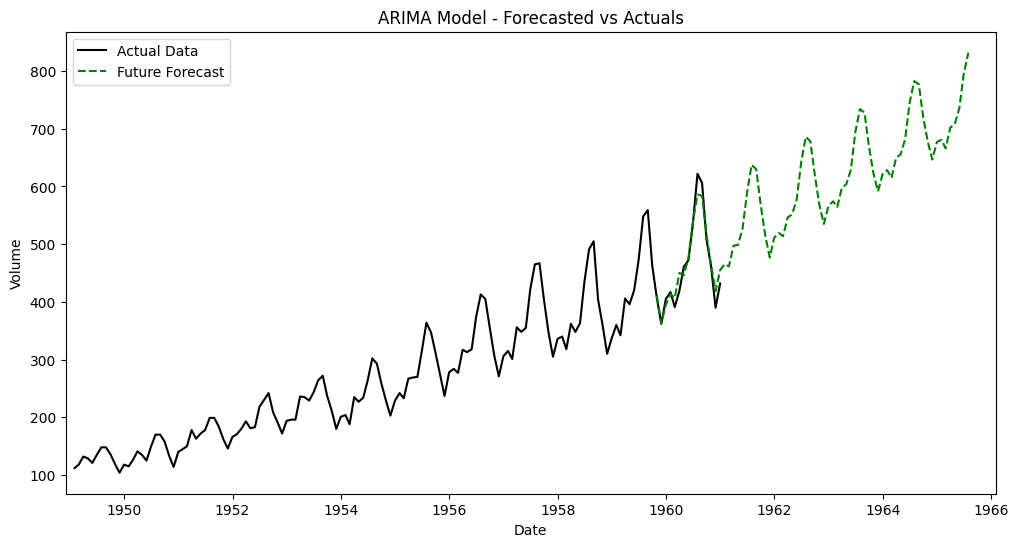

In [35]:
total_forecast = create_total_forecast(data_monthly, trend, seasonal, residual)

In [38]:
find_data_interpretations(total_forecast, 'Volume', 'total_forecast')

Mean Absolute Error (MAE) – Average absolute difference between actual & predicted values: 
MAE: 9.52
Mean Absolute Percentage Error (MAPE) – Percentage error relative to actual values: 
MAPE: 2.25%
Root Mean Squared Error (RMSE) – Penalizes larger errors more than MAE.:
RMSE: 13.26
R-Squared (R^2) – Shows how well the model is doing on a scale from 0-1:
R-Squared: 0.93


In [3]:
total_forecast = pd.read_csv('total_forecast.csv')